## 텍스트 분류 - 일상문장 분류 (중립, 긍정, 부정; 멀티클래스 분류_RNN)

In [18]:
# 사용 모듈 import 할게요.
import numpy as np
import matplotlib.pyplot as plt

# 전처리를 위한 konlpy의 Okt import 할게요.
from konlpy.tag import Okt

# 임베딩을 위한 gensim import 할게요.
import gensim

# tensorflow.kears 쪽 모듈 import 할게요.
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [3]:
# 파일 경로 설정할게요.
data_path = '../data/Chatbot_data-master/ChatbotData.csv'

# pandas로 파일 읽어서 DataFrame 만들게요
df = pd.read_csv(data_path)
print(df.columns)

Index(['Q', 'A', 'label'], dtype='object')


In [4]:
# 전에 설명드렸던거랑은 
# 다른방법으로 진행해볼게요.

# np.random.seed(number)를 사용하면 이 셀에서
# np.random의 값이 안바껴요.
np.random.seed(0)

# DataFrame에서 'Q', 'label'컬럼의 데이터만 가지고 와서
# .values로 인덱스, 컬럼 제외한 데이터만 가지고 올게요.
sentences = df[['Q', 'label']].values

# 앞에서 5개 데이터만 확인할게요.
print(sentences[:5])
# 데이터 전체 길이 확인할게요.
print(len(sentences))

# 이 데이터가 0 / 1 / 2 로 나눠져 있는데, 데이터가 안섞여있어요.
# 전체에서 무작위로 70% 뽑기 위해서 train_mask를 사용할게요.
# np.random.choice(length, replace, size) 함수는
# 0~length까지의 숫자 중에 size만큼의 수를 random으로 추출하는 거에요.
# replace=True면 중복을 허락하고, replace=False면 중복을 허락안해요.
train_mask = np.random.choice(len(sentences), replace=False, size=int(len(sentences)*0.7))

# test_mask는 나머지 30%를 위한거에요.
# 전체와 동일한 길이의 array를 np.arange로 생성하고
test_mask = np.arange(len(sentences))
# set()의 함수 중 차집합 함수를 사용해서
# 전체에서 학습에 사용할 70%인 train_mask를 빼주는 거에요.
test_mask = np.asarray(list(set(test_mask).difference(set(train_mask))))

#데이터 한번 확인해보세요.
print(train_mask)
print(test_mask)
print(len(train_mask))
print(len(test_mask))

[['12시 땡!' 0]
 ['1지망 학교 떨어졌어' 0]
 ['3박4일 놀러가고 싶다' 0]
 ['3박4일 정도 놀러가고 싶다' 0]
 ['PPL 심하네' 0]]
11823
[2524 8998 8290 ... 1368 1489 5860]
[   0 8192    2 ... 8183 8185 8186]
8276
3547


In [6]:
# 전체 데이터를 학습데이터랑
# 평가 데이터로 나눌게요.

# 각각을 저장할 딕셔너리를 생성하고,
train_dict = {}
test_dict = {}

# enumerate()함수로 데이터의 위치와 데이터를 함께 받아올게요.
for idx, sentence_label in enumerate(sentences):
    
    # 제일 처음에 한번만 데이터 출력해서 확인할게요.
    if idx == 0:
        print(sentence_label)
        
    # sentence_label이 [문장, label]로 되어있으니까
    # 나눠서 받아줄게요.
    sentence, label = sentence_label
    
    # 현재 데이터의 위치가 train_mask안에 있으면
    # 학습 딕셔너리에 저장하고
    if idx in train_mask:
        train_dict[sentence] = label
    # 그게 아니면 평가 딕셔너리에 저장할게요.
    else:
        test_dict[sentence] = label

['12시 땡!' 0]


In [9]:
# 제거할 품사 설정해 줄게요.
stop_pos = ['Punctuation', 'Hashtag', 'Foreign', 'URL', 'Email', 'Number', 'ScreenName', 'Alpha']

In [10]:
# 학습 문장으로 words_set 생성, 업데이트하면서
# 학습 문장의 최대 길이 설정할게요.
okt = Okt()
words_set = set()
max_len_train = 0
max_len_train_idx = 0

# 먼저 train에서 데이터 받아올게요.
for idx, train_sentence in enumerate(train_dict.keys()):
    sentence = train_sentence.strip()
    
    # 분류라서 문장이 사람에게 익숙하지 않아도 되니까,
    # normalize랑 stemming 진행해 줄게요.
    words = okt.pos(sentence, norm=True, stem=True)
    
    # 토크나이즈된 문장에서
    # 제거할 품사에 해당하는 단어지우고 사용할게요.
    words = [word for word, pos in words if pos not in stop_pos ]

    # 학습 문장의 최대길이 찾아 줄게요.
    if len(words) > max_len_train:
        max_len_train = len(words)
        max_len_train_idx = idx
    
    # words_set 업데이트 할게요.
    words_set.update(words)

In [11]:
# 테스트 문장으로도 words_set 업데이트하면서
# 테스트 문장의 최대 길이 설정할게요.
max_len_test = 0
max_len_test_idx = 0

# test에서 데이터 받아올게요.
for idx, test_sentence in enumerate(test_dict.keys()):
    sentence = test_sentence.strip()
    
    # 분류라서 문장이 사람에게 익숙하지 않아도 되니까,
    # normalize랑 stemming 진행해 줄게요.
    words = okt.pos(sentence, norm=True, stem=True)
    
    # 토크나이즈된 문장에서
    # 제거할 품사에 해당하는 단어지우고 사용할게요.
    words = [word for word, pos in words if pos not in stop_pos ]

    # 테스트 문장의 최대길이 찾아 줄게요.
    if len(words) > max_len_test:
        max_len_test = len(words)
        max_len_test_idx = idx
    
    # words_set 업데이트 할게요.
    words_set.update(words)

In [12]:
# 전체 문장에서 최대길이 찾아 줄게요.
max_len = max(max_len_train, max_len_test)
print(max_len)

# 학슴 및 테스트 데이터에서
# 각각의 최대길이 문장 확인해 볼게요.
print(max_len_train_idx)
print(max_len_test_idx)
print(list(train_dict.keys())[max_len_train_idx], '\n')
print(list(test_dict.keys())[max_len_test_idx])

20
7633
2577
제가 좋아하는 사람이 맘 잡고 공부해야할 것 같다고 기다려달라는데 제 맘이 안별할까요? 

헤어지고 뜨문뜨문 연락은 다시 시작하긴 뭐하고 남주긴 아까운 뭐 이런마음인건가?


In [14]:
# 테스트 데이터의 최대길이 문장,
# 토크나이즈 어떻게 되는지 확인해볼게요.
text = '헤어지고 뜨문뜨문 연락은 다시 시작하긴 뭐하고 남주긴 아까운 뭐 이런마음인건가?'
words = okt.pos(text, norm=True, stem=True)

# 토크나이즈만 진행한 문장이구요,
print([word for word, _ in words])

# pos filtering 까지 진행한 문장이에요.
print([word for word, pos in words if pos not in stop_pos])

['헤어지다', '뜨다', '문', '뜨다', '문', '연락', '은', '다시', '시작', '하다', '뭐', '하고', '남다', '아깝다', '뭐', '이런', '마음', '인', '건가', '?']
['헤어지다', '뜨다', '문', '뜨다', '문', '연락', '은', '다시', '시작', '하다', '뭐', '하고', '남다', '아깝다', '뭐', '이런', '마음', '인', '건가']


In [15]:
# words_set 길이랑 데이터 확인할게요.
words_set = list(sorted(words_set))

# zero-padding을 위해서 0번 자리에 '' 공백 하나 넣어줄게요.
words_set.insert(0, '')

print(len(words_set))
print(words_set[:10])
print(words_set[-10:])

4504
['', 'ㅋ', 'ㅋㅋ', 'ㅎ', 'ㅎㅎ', 'ㅎㅎㅎ', 'ㅜ', 'ㅜㅜ', 'ㅠ', 'ㅠㅠ']
['힐링', '힘', '힘겹다', '힘껏', '힘내다', '힘내렵니', '힘드다', '힘들다', '힘차다', '힙듭니']


In [16]:
# 모델을 위한 형태로 
# 문장을 변경하는 함수 작성할게요.

def make_shape4model(sentence_label_dict):
    # 단어 임베딩을 위해서 word2vec pre-trained 모델 사용할게요.
    # gensim으로 모델 불러올게요.
    w2v = gensim.models.Word2Vec.load('../data/ko.bin')
    # 모델의 입력으로 사용할 데이터
    # 저장하는 temp_x 생성할게요.
    temp_x = []
    
    # 모델의 출력으로 사용할 데이터 
    # 저장하는 temp_y 생성할게요.
    temp_y = []

    # 입력 받은 문장 가져올게요.
    for sentence in sentence_label_dict.keys():
        
        # 문장에 다시 normalization이랑 stemming 진행하면서 
        # 단어만 가져올게요.
        words = okt.pos(sentence, norm=True, stem=True)
        words = [word for word, _ in words]
        
        # 전처리 진행 후 남는 단어가 없으면
        # 넘어갈게요.
        if not words:
            continue
        
        # 단어 임베딩은 word2vec pre-trained 모델로 진행할게요.
        # try-except문으로 pre-trained 모델에 학습 안된 단어는
        # 넘어가도록 해서 진행할게요.
        sent = []
        for word in words:
            try: 
                sent.append(w2v.wv[word])
            except KeyError:
                continue
        
        # 최대 문장의 길이만큼 
        # 문장의 앞쪽으로 zero-padding 진행할게요.
        padding_size = max_len-len(sent)
        for i in range(padding_size):
            sent.insert(0, np.zeros(200))
        
        # zero-padding까지 진행된 문장을
        # temp_x에 저장할게요.
        temp_x.append(sent)
        
        # Dictionary에 key로 sentence 집어넣으면
        # 나오는 레이블 그대로 temp_y에 저장할게요.
        temp_y.append(sentence_label_dict[sentence])
        
    # temp_x는 numpy.ndarray로 바꾸로 float으로 타입 변경하고,
    # temp_y는 to_categorical로 One-Hot 인코딩 진행해서 반환할게요.
    return np.asarray(temp_x).astype('float'), to_categorical(temp_y)

In [19]:
# 학습 문장이랑 테스트 문장을 
# 각각 모델의 입력이랑 출력으로 나눌게요.

x_train, y_train = make_shape4model(train_dict)
x_test, y_test = make_shape4model(test_dict)

In [20]:
# 데이터 확인해 볼게요
# 나오는 shape은 (문장의 수, 단어의 개수, 한 단어의 벡터) 에요.
print(len(x_train))
print(x_train.shape)
print(len(y_train))
print(y_train.shape)

print(len(x_test))
print(x_test.shape)
print(len(y_test))
print(y_test.shape)

8188
(8188, 20, 200)
8188
(8188, 3)
3530
(3530, 20, 200)
3530
(3530, 3)


In [22]:
# Loss 확인용 클래스 작성
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [28]:
# 모델 생성 및 컴파일
history = LossHistory()
history.init()

model = Sequential()
model.add(LSTM(units=64, input_shape=(None, 200)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# 생성한 모델의 출력 형태 확인할게요.
x = np.asarray(x_train[0]).astype('float').reshape(1, x_train[0].shape[0], x_train[0].shape[1])
pred = model.predict(x)
print(pred)

[[0.3329382  0.36709553 0.29996628]]


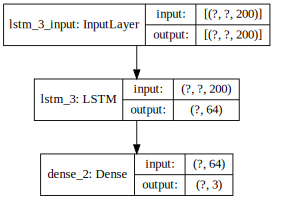

In [32]:
# SVG로 시각화 해볼게요.
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [31]:
# 모델 학습
model.fit(x_train, y_train, epochs=10, batch_size=128, callbacks=[history])

Epoch 1/10
64/64 [==============================] - 1s 11ms/step - loss: 0.8705 - accuracy: 0.6088
Epoch 2/10
64/64 [==============================] - 1s 10ms/step - loss: 0.6909 - accuracy: 0.7076
Epoch 3/10
64/64 [==============================] - 1s 12ms/step - loss: 0.6224 - accuracy: 0.7413
Epoch 4/10
64/64 [==============================] - 1s 10ms/step - loss: 0.5701 - accuracy: 0.7655
Epoch 5/10
64/64 [==============================] - 1s 11ms/step - loss: 0.5218 - accuracy: 0.7860
Epoch 6/10
64/64 [==============================] - 1s 10ms/step - loss: 0.4837 - accuracy: 0.8021
Epoch 7/10
64/64 [==============================] - 1s 10ms/step - loss: 0.4498 - accuracy: 0.8181
Epoch 8/10
64/64 [==============================] - 1s 10ms/step - loss: 0.4134 - accuracy: 0.8352
Epoch 9/10
64/64 [==============================] - 1s 11ms/step - loss: 0.3820 - accuracy: 0.8517
Epoch 10/10
64/64 [==============================] - 1s 10ms/step - loss: 0.3598 - accuracy: 0.8577


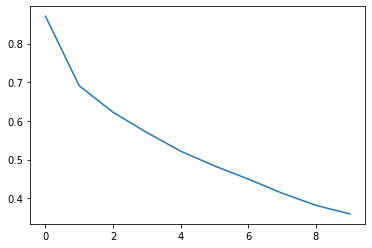

In [33]:
# Loss 확인할게요.
loss = history.losses
epochs = range(len(loss))
plt.plot(epochs, loss)
plt.show()

In [34]:
# 모델의 정확도만 평가하는 함수작성 할게요.
def _eval(sentences, labels):
    correct_cnt = 0
    
    # 문장이랑 레이블 받아서 진행할게요.
    for sentence, label in zip(sentences, labels):
        # 모델 입력 데이터 array로 바꾸면서, 타입도 변경할게요.
        x = np.asarray(sentence).astype('float')
        
        # RNN 계열은 입력이 3차원이기 때문에 shape 변경할게요.
        x = x.reshape(1, x.shape[0], x.shape[1])
        
        # label은 (0, 1, 2)로 되어있으니까, max값의 인덱스로
        # label 설정할게요.
        y = list(label)
        y = y.index(max(y))
        
        # 모델로 x 분류 진행할게요.
        predict = np.squeeze(model.predict(x))
        predict = predict.argmax()
        if predict == y:
            correct_cnt += 1
    return correct_cnt

In [35]:
# 모델에 학습 데이터로 모델 정확도 확인할게요.
# 조금 오래걸려요. 

ccnt = _eval(x_train, y_train)
print(ccnt, ' / ', len(x_train),' : ', ccnt/len(x_train))

7213  /  8188  :  0.8809233023937469


In [36]:
# 평가 데이터로 모델 정확도 확인할게요.
# 조금 오래걸려요.

ccnt = _eval(x_test, y_test)
print(ccnt, ' / ', len(x_test), ' : ' , ccnt/len(x_test))

2584  /  3530  :  0.7320113314447592
